In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras.backend as K
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
#from keras.utils import np_utils
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, SpatialDropout1D
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer

from keras import callbacks
from keras.callbacks import CSVLogger

#from utilss import utils

import os

#traindata = pd.read_csv('preprocessed_train_multiclass(a)_new.csv', header=None)
#testdata = pd.read_csv('preprocessed_test_multiclass(a)_new.csv', header=None)
'''
X=pd.read_csv (r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\ptrain2_sli121.csv", header=None )
T=pd.read_csv (r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\ptrain2_sli11.csv", header=None )
C=pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\ptrain2_sli1_label.csv",header=None)
Y=pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\ptrain2_sli2_label.csv",header=None)
X = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\ptrain_1.csv", header=None)
Y = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\train_label.csv", header=None)

T = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\pva1\pva_1.csv", header=None)
C = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\pva1\pva_label.csv", header=None)'''
f1 = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\tr1\t\sptrain1_f1_bert.csv", header=None)
f2 = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\tr1\t\sptrain1_f2_bert.csv", header=None)
f1_label = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\tr1\t\f1_label.csv", header=None)
f2_label = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\tr1\t\f2_label.csv", header=None)

X = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\tr1\t\sptrain1_t1_bert.csv", header=None)
Y = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\tr1\t\t1_label.csv", header=None)
X = X.append ( f1 )
X = X.append ( f2 )
Y = Y.append ( f1_label )
Y = Y.append ( f2_label )

T = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\tr1\t\sptrain1_t2_bert.csv", header=None)
C = pd.read_csv(r"E:\学习心得\data\cic-ids2018\02-03\ptrain1\tr1\t\t2_label.csv", header=None)

X1 = X
T1 = T
X1.fillna(0,inplace=True)
X1.replace([np.inf,-np.inf],1,inplace=True)
T1.fillna(0,inplace=True)
T1.replace([np.inf,-np.inf],1,inplace=True)
#X1.value_counts('Label')
'''
for index in X1.columns:
    X1[index]=X1[index].fillna(0,inplace=True)
    X1[index]=X1[index].replace([np.inf,-np.inf],1,inplace=True)
'''

#scaler = Normalizer().fit(X1)
#trainX = scaler.transform(X1)
trainX =  np.array(X1)

#scaler = Normalizer().fit(T1)
#testT = scaler.transform(T1)
testT = np.array(T1)
y_train1 = np.array(Y)
y_test1 = np.array(C)

y_train = to_categorical(y_train1)
y_test = to_categorical(y_test1)

# reshape input to be [samples, time steps, features]
X_train = trainX
X_test = testT

print (trainX.shape )
X_train = np.reshape(trainX, (trainX.shape[0],32,24))
X_test = np.reshape(testT, (testT.shape[0],32,24))

# Add a channels dimension
X_train = X_train[..., tf.newaxis].astype("float32")
X_test = X_test[..., tf.newaxis].astype("float32")
new_model = tf.keras.models.load_model('saved_model/temp/bert_model')

# Check its architecture
new_model.summary()
# Evaluate the restored model
optimizer = tf.keras.optimizers.Adam()

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

new_model.compile(optimizer, test_loss)
loss, acc = new_model.evaluate(X_test, y_test1, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(X_test).shape)


class myMetrics:
    def __init__(self, X_test, Y_test, model):
        self.model = model
        self.Y_test = Y_test
        self.X_test = X_test
        self.y_pred = self.model.predict(self.X_test)

    def Precision(self):
        """精确率"""
        self.Y_test=self.Y_test.astype ( np.float32)
        tp = K.sum(K.round(K.clip(self.Y_test * self.y_pred, 0, 1)))  # true positives
        pp = K.sum(K.round(K.clip(self.y_pred, 0, 1)))  # predicted positives
        '''
        print ( type (tp))
        print ( tp.dtype)
        print ( type (pp))
        print ( pp.dtype)
        print ( type (K.epsilon()))
        '''
        
        #print ( K.epsilon().dtype)
        precision = tp / (pp + K.epsilon())
        self.precision = precision
        return precision

    def Recall(self):
        """召回率"""
        tp = K.sum(K.round(K.clip(self.Y_test * self.y_pred, 0, 1)))  # true positives
        pp = K.sum(K.round(K.clip(self.Y_test, 0, 1)))  # possible positives
        recall = tp / (pp + K.epsilon())
        self.recall = recall
        return recall

    def F1(self):
        """F1-score"""
        try:
            precision = self.precision
            recall = self.recall
        except:
            precision = self.Precision()
            recall = self.Recall()
        f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        self.f1 = f1
        return f1

    def LossAccuracy(self):
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=Adam(lr=1e-4),
                           metrics=['accuracy'])
        metric = self.model.evaluate(x=self.X_test, y=self.Y_test, verbose=0)
        print(self.model.metrics_names)
        self.accuracy = metric[1]
        self.loss = metric[0]
        return metric

    def auto(self):
        self.Precision()
        self.Recall()
        self.F1()
        self.LossAccuracy()
        return self.precision, self.recall, self.f1, self.accuracy, self.loss


def mktest(lines=None, size=(224, 224)):
    if lines == None:
        with open('../../../Metrics/cate.txt', 'r') as l:
            lines = l.readlines()
            l.close()
    img_dir = '../../../Metrics/imgs/'
    imgs = []
    gt = []
    for line in lines:
        imgs.append(img_dir + line.split(';')[0])
        gt.append(int(line.split(';')[1]))
    X_test = []
    Y_test = gt
    for il in imgs:
        img = cv2.imread(il)
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
            pass

        img = np.float32(img / 255)
        X_test.append(img)
    X_test = utils.resize_image(X_test, (224, 224))
    X_test = X_test.reshape(-1, 224, 224, 3)
    Y_test = np_utils.to_categorical(np.array(Y_test), num_classes=6)
    return X_test, Y_test


def get_pre(Y_test, X_test):
    Y_pre = model.predict(X_test)
    np.savez('./data.npz', X_test, Y_test, Y_pre)
    return Y_pre


if __name__ == '__main__':
    #data, gt = mktest()
    data, gt = X_train,y_train1
    # get_pre(gt, data)
    mym = myMetrics(data, gt, new_model)
    precision, recall, f1, loss, accuracy = mym.auto()
    print ( precision)
    print ( recall )
    print ( f1)
    print ( loss)
    print ( accuracy )
    #np.savez('./result.npz', precision, recall, f1, loss, accuracy)


(87962, 768)
Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          multiple                  0         
_________________________________________________________________
dense_9 (Dense)              multiple                  32832     
_________________________________________________________________
conv2d_15 (Conv2D)           multiple                  320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_16 (Conv2D)           multiple                  18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_17 (Conv2D)           multiple      

In [16]:
re1=np.load('./result.npz',allow_pickle=True)
re1.files
precision1, recall1, f11, loss1, accuracy1=re1['arr_0'],re1['arr_1'],re1['arr_2'],re1['arr_3'],re1['arr_4']
print ( type (precision1 ))
print ( precision1.shape)
print ( precision1)
print ( recall1 )
print ( f11)
print ( loss1)
print ( accuracy1 )

<class 'numpy.ndarray'>
()
0.91905624
0.88614404
0.90230006
0.9021282196044922
0.2896009385585785


In [18]:
#X_train = X_train[..., tf.newaxis].astype("float64")
if __name__ == '__main__':
    #data, gt = mktest()
    data, gt = X_test,y_test1
    # get_pre(gt, data)
    mym = myMetrics(data, gt, new_model)
    precision, recall, f1, loss, accuracy = mym.auto()
    #print ( precision.shape)
    print ( precision)
    print ( recall )
    print ( f1)
    print ( loss)
    print ( accuracy )
    #np.savez('./result2.npz', precision, recall, f1, loss, accuracy)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'float'>
['loss', 'accuracy', 'test_loss']
()
tf.Tensor(0.9096246, shape=(), dtype=float32)
tf.Tensor(0.8737409, shape=(), dtype=float32)
tf.Tensor(0.89132166, shape=(), dtype=float32)
0.8907937407493591
0.3170267641544342


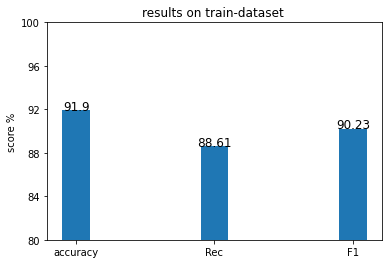

In [24]:
import matplotlib.pyplot as plt
plt.title('results on train-dataset ')   #添加标题名称，可以指定位置、颜色、字体大小等参数
#plt.xlabel('')      #添加x轴名称，可以指定位置、颜色、字体大小等参数
plt.bar(['accuracy','Rec','F1'],[91.90,88.61,90.23],width=0.20)
plt.ylabel('score %')      #添加y轴名称，可以指定位置、颜色、字体大小等参数
#plt.xlim((70,100))      #指定x轴范围，只能确定一个数值区间，无法使用字符串标识
plt.ylim((80,100))      #指定y轴范围，只能确定一个数值区间，无法使用字符串标识
#plt.xticks([' ','训练集',' ','测试集',' '])  #指定x轴刻度的数目与取值
plt.yticks([80,84,88,92,96,100])  #指定y轴刻度的数目与取值
plt.text('accuracy',91.90,91.90,ha='center',fontsize=12)
plt.text('Rec',88.61,88.61,ha='center',fontsize=12)
plt.text('F1',90.23,90.23,ha='center',fontsize=12)
plt.show()                         #在本机显示图形


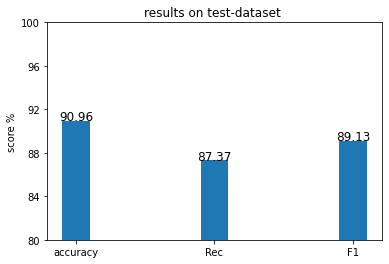

In [25]:
plt.title('results on test-dataset ')   #添加标题名称，可以指定位置、颜色、字体大小等参数
#plt.xlabel('')      #添加x轴名称，可以指定位置、颜色、字体大小等参数
plt.bar(['accuracy','Rec','F1'],[90.96,87.37,89.13],width=0.20)
plt.ylabel('score %')      #添加y轴名称，可以指定位置、颜色、字体大小等参数
#plt.xlim((70,100))      #指定x轴范围，只能确定一个数值区间，无法使用字符串标识
plt.ylim((80,100))      #指定y轴范围，只能确定一个数值区间，无法使用字符串标识
#plt.xticks([' ','训练集',' ','测试集',' '])  #指定x轴刻度的数目与取值
plt.yticks([80,84,88,92,96,100])  #指定y轴刻度的数目与取值
plt.text('accuracy',90.96,90.96,ha='center',fontsize=12)
plt.text('Rec',87.37,87.37,ha='center',fontsize=12)
plt.text('F1',89.13,89.13,ha='center',fontsize=12)
plt.show()                         #在本机显示图形